# Copyright Netherlands eScience Center<br>
** Function     : Emotion recognition and forecast with BBConvLSTM** <br>
** Author       : Yang Liu** <br>
** First Built  : 2020.06.19 ** <br>
** Contributor  : Tianyi Zhang (Centrum Wiskunde & Informatica)<br>
** First Built  : 2020.06.19 ** <br>
** Last Update  : 2020.07.22 ** <br>
** Library      : Pytorth, Numpy, os, DLACs, matplotlib **<br>
Description     : This notebook serves to test the prediction skill of deep neural networks in emotion recognition and forecast. The Bayesian convolutional Long Short Time Memory neural network with Bernoulli approximate variational inference is used to deal with this spatial-temporal sequence problem. We use Pytorch as the deep learning framework. <br>
<br>
** Many to one prediction.** <br>

Return Values   : Time series and figures <br>

**This project is a joint venture between NLeSC and CWI** <br>

The method comes from the study by Shi et. al. (2015) Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting. <br>

In [1]:
%matplotlib inline

import sys
# for data loading
import os
# for pre-processing and machine learning
import numpy as np
#import sklearn
#import scipy
import torch
import torch.nn.functional


sys.path.append("../")
import nemo
import nemo.ConvLSTM
import nemo.BBConvLSTM
import nemo.function

# for visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
# please specify data path
datapath = 'C:\\Users\\nosta\\NEmo\\Data_CASE'
output_path = 'C:\\Users\\nosta\\NEmo\\results'
model_path = 'C:\\Users\\nosta\\NEmo\\models'

In [3]:
if __name__=="__main__":
    print ('*********************** extract variables *************************')
    data = np.load(os.path.join(datapath,"data_10s.npz"))
    #data = np.load(os.path.join(datapath, "data_2s.npz"))
    #data = np.load(os.path.join(datapath, "data_0.5s.npz"))
    #################################################################################
    #########                        data gallery                           #########
    #################################################################################
    sample = data["Samples"][:] # (batch_size, sample_size, channels)
    label_c = data["Labels_c"][:] # (batch_size, sample_size, 2)
    label = data["Labels"][:] # (batch_size, 2)
    subject = data["Subject_id"][:] # (batch_size, 2)
    video_label = data["Video_labels"][:] # (batch_size,1)
    
    # leave-one-out training and testing
    num_s = 2
    sample_train = sample[np.where(subject!=num_s)[0],:,0:5]
    sample_test = sample[np.where(subject==num_s)[0],:,0:5]
    
    label_c_train = label_c[np.where(subject!=num_s)[0],:,:] / 10 # normalize
    label_c_test = label_c[np.where(subject==num_s)[0],:,:] / 10 # normalize

*********************** extract variables *************************


In [8]:
print(len(subject[subject==0]))

123


In [4]:
    #################################################################################
    #########                      pre-processing                           #########
    #################################################################################
    # choose the target dimension for reshaping of the signals
    batch_train_size, sample_size, channels = sample_train.shape
    batch_test_size, _, _ = sample_test.shape
    _, _, label_channels = label_c_train.shape
    x_dim = 5
    y_dim = 5
    series_len = sample_size // (y_dim * x_dim)
    # reshape the input and labels
    sample_train_xy = np.reshape(sample_train,[batch_train_size, series_len, y_dim, x_dim, channels])
    sample_test_xy = np.reshape(sample_test,[batch_test_size, series_len, y_dim, x_dim, channels])
    label_c_train_xy = np.reshape(label_c_train,[batch_train_size, series_len, y_dim, x_dim, label_channels])
    label_c_test_xy = np.reshape(label_c_test,[batch_test_size, series_len, y_dim, x_dim, label_channels])
    #################################################################################
    #########                       normalization                           #########
    #################################################################################
    print('================  extract individual variables  =================')
    sample_1 = sample_train_xy[:,:,:,:,0]
    sample_2 = sample_train_xy[:,:,:,:,1]
    sample_3 = sample_train_xy[:,:,:,:,2]
    sample_4 = sample_train_xy[:,:,:,:,3]
    sample_5 = sample_train_xy[:,:,:,:,4]
    
    label_c_valance = label_c_train_xy[:,:,:,:,0]
    label_c_arousal = label_c_train_xy[:,:,:,:,1]
    
    label_c_test_valance = label_c_test_xy[:,:,:,:,0]
    label_c_test_arousal = label_c_test_xy[:,:,:,:,1]
    
    # using indicator for training
    # video_label_3D = np.repeat(video_label[:,np.newaxis,:],series_len,1)
    # video_label_4D = np.repeat(video_label_3D[:,:,np.newaxis,:],y_dim,2)
    # video_label_xy = np.repeat(video_label_4D[:,:,:,np.newaxis,:],x_dim,3)
    # video_label_xy.astype(float)

================  extract individual variables  =================


In [5]:
    # first check of data shape
    print(batch_train_size)
    print(batch_test_size)
    print(sample.shape)
    print(label_c.shape)
    print(label.shape)
    print(subject.shape)
    print(video_label.shape)
    # check of reshape
    print(label_c_train_xy.shape)

3567
123
(3690, 1000, 8)
(3690, 1000, 2)
(3690, 2)
(3690, 1)
(3690, 1)
(3567, 40, 5, 5, 2)


# Procedure for LSTM <br>
** We use Pytorth to implement LSTM neural network with time series of climate data. ** <br>

In [5]:
    print ('*******************  create basic dimensions for tensor and network  *********************')
    # specifications of neural network
    input_channels = 5
    hidden_channels = [4, 3, 2] # number of channels & hidden layers, the channels of last layer is the channels of output, too
    #hidden_channels = [3, 3, 3, 3, 2]
    #hidden_channels = [2]
    kernel_size = 3
    # here we input a sequence and predict the next step only
    learning_rate = 0.01
    num_epochs = 100
    # probability of dropout
    p = 0.5 # 0.5 for Bernoulli (binary) distribution
    print (torch.__version__)
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()
    print("Is CUDA available? {}".format(use_cuda))
    # CUDA settings torch.__version__ must > 0.4
    # !!! This is important for the model!!! The first option is gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print ('*******************  cross validation and testing data  *********************')
    # mini-batch
    mini_batch_size = 64
    # iterations
    iterations = batch_train_size // mini_batch_size
    if batch_train_size % mini_batch_size != 0:
        extra_loop = "True"
        iterations += 1

*******************  create basic dimensions for tensor and network  *********************
1.1.0
Is CUDA available? True
*******************  cross validation and testing data  *********************


In [15]:
    %%time
    print ('*******************  load exsited LSTM model  *********************')
    # load model parameters
    model = nemo.BBConvLSTM.BBConvLSTM(input_channels, hidden_channels, kernel_size).to(device)
    model.load_state_dict(torch.load(os.path.join(model_path, 'BBconvlstm_emotion_hl_3_kernel_3_lr_0.01_epoch_20_mini_64_validSIC.pkl'),
                                     map_location=device))
    #model = torch.load(os.path.join(output_path, 'Barents','convlstm_emotion_hl_1_kernel_3_lr_0.01_epoch_500_validSIC.pkl'))
    print(model)
    # check the sequence length (dimension in need for post-processing)
    _, sequence_len, height, width = sample_1.shape

*******************  load exsited LSTM model  *********************
BBConvLSTM(
  (cell0): BBConvLSTMCell(
    (Wxi): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxc): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whc): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxo): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Who): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (dropout): Dropout2d(p=0.5)
  )
  (cell1): BBConvLSTMCell(
    (Wxi): Conv2d(4, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(4,

In [6]:
    %%time
    print ('*******************  run LSTM  *********************')
    print ('The model is designed to make many to one prediction.')
    print ('A series of multi-chanel variables will be input to the model.')
    print ('The model learns by verifying the output at each timestep.')
    # check the sequence length
    _, sequence_len, height, width = sample_1.shape
    #_, sequence_len, height, width = sample_1_norm.shape
    # initialize our model
    model = nemo.BBConvLSTM.BBConvLSTM(input_channels, hidden_channels, kernel_size, p).to(device)
    loss_fn = torch.nn.MSELoss(size_average=True)
    # stochastic gradient descent
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Adam optimizer
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(model)
    print(loss_fn)
    print(optimiser)

*******************  run LSTM  *********************
The model is designed to make many to one prediction.
A series of multi-chanel variables will be input to the model.
The model learns by verifying the output at each timestep.


G:\Anaconda\lib\site-packages\torch\nn\_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


BBConvLSTM(
  (cell0): BBConvLSTMCell(
    (Wxi): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxc): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whc): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxo): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Who): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (dropout): Dropout2d(p=0.5)
  )
  (cell1): BBConvLSTMCell(
    (Wxi): Conv2d(4, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(4, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Co

In [7]:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print (name)
            print (param.data)
            print (param.size())
            print ("=========================")

cell0.Wxi.weight
tensor([[[[ 0.1084, -0.0190,  0.1306],
          [ 0.0260,  0.0243, -0.0207],
          [ 0.1276, -0.0834,  0.0025]],

         [[-0.0223, -0.0352, -0.0058],
          [ 0.0417, -0.0283,  0.0526],
          [ 0.1246, -0.0577, -0.1181]],

         [[-0.1245,  0.0817,  0.1014],
          [-0.0671,  0.0313, -0.0489],
          [-0.0313,  0.0005, -0.1422]],

         [[-0.0084,  0.0828,  0.1182],
          [-0.0288,  0.1278, -0.0326],
          [-0.0427, -0.0182, -0.0553]],

         [[ 0.0400,  0.0016,  0.1389],
          [ 0.1482, -0.0620, -0.1144],
          [-0.1018, -0.0351,  0.1397]]],


        [[[ 0.1151,  0.1056, -0.0326],
          [-0.0535, -0.0559, -0.1188],
          [-0.0465,  0.0553, -0.0738]],

         [[-0.1192, -0.0871, -0.1266],
          [ 0.1402, -0.0298, -0.0902],
          [ 0.1360, -0.1126, -0.0650]],

         [[-0.0211,  0.0866,  0.0216],
          [ 0.1102,  0.1165, -0.0725],
          [ 0.0133, -0.1350, -0.0399]],

         [[-0.1043,  0.0923, 

          [-0.0972, -0.1416,  0.0200]]]], device='cuda:0')
torch.Size([4, 4, 3, 3])
cell0.Wxc.weight
tensor([[[[ 0.1216, -0.0153,  0.0080],
          [-0.1282,  0.0439, -0.0221],
          [ 0.0116, -0.0355,  0.0496]],

         [[ 0.0709,  0.0758, -0.0295],
          [-0.1083,  0.0286,  0.0902],
          [-0.1015,  0.0119, -0.0876]],

         [[-0.0336,  0.0491, -0.0391],
          [ 0.1017, -0.0566, -0.1385],
          [ 0.1188,  0.0262, -0.0449]],

         [[ 0.0029,  0.0795,  0.0642],
          [ 0.1174, -0.0826, -0.0040],
          [ 0.0671,  0.1014,  0.1131]],

         [[-0.1179,  0.0421, -0.1064],
          [ 0.1318,  0.0464,  0.0857],
          [ 0.0976, -0.1416, -0.0526]]],


        [[[-0.0587,  0.0502,  0.1242],
          [-0.1166,  0.1243,  0.0999],
          [ 0.0927,  0.0573,  0.1170]],

         [[-0.0981, -0.0371,  0.0938],
          [-0.0109,  0.1468,  0.0165],
          [ 0.0946,  0.0650,  0.0346]],

         [[ 0.1426,  0.0594, -0.0937],
          [-0.1134, -0.01

          [ 0.0523, -0.0354,  0.1408]]]], device='cuda:0')
torch.Size([4, 4, 3, 3])
cell1.Wxi.weight
tensor([[[[-0.0541,  0.1286,  0.1305],
          [-0.1320, -0.0137, -0.0688],
          [-0.1114,  0.1093,  0.0486]],

         [[ 0.1404, -0.0936, -0.1651],
          [ 0.0569, -0.0563,  0.1537],
          [ 0.0970, -0.1520,  0.0628]],

         [[ 0.1174,  0.0103,  0.1445],
          [ 0.0336, -0.1559,  0.0374],
          [ 0.1499, -0.1356, -0.0068]],

         [[-0.0921,  0.0067,  0.0165],
          [-0.0897, -0.1511, -0.0096],
          [ 0.1541, -0.0068,  0.1142]]],


        [[[-0.0957, -0.1070,  0.0425],
          [ 0.0263,  0.1003,  0.1110],
          [ 0.1373, -0.0672,  0.0398]],

         [[ 0.0473, -0.0398, -0.1586],
          [-0.0644, -0.0873,  0.1339],
          [-0.1280, -0.1213,  0.1089]],

         [[ 0.1605, -0.0730,  0.1449],
          [-0.1380, -0.0833,  0.0527],
          [ 0.1164,  0.0219,  0.1079]],

         [[-0.0048, -0.0472, -0.0261],
          [-0.0031,  0.07

          [-0.1124, -0.1672, -0.1273]]]], device='cuda:0')
torch.Size([3, 3, 3, 3])
cell1.Wxo.weight
tensor([[[[ 0.0350,  0.1338, -0.1663],
          [ 0.1359, -0.0773, -0.0682],
          [-0.0425,  0.0985,  0.0725]],

         [[-0.1536,  0.0049,  0.0799],
          [-0.1383, -0.0110, -0.0377],
          [ 0.0257,  0.1564,  0.0617]],

         [[ 0.0257, -0.0030,  0.0764],
          [ 0.1395,  0.0652, -0.0463],
          [ 0.0352,  0.0706,  0.0609]],

         [[ 0.0243, -0.0891,  0.1410],
          [ 0.0869, -0.1454, -0.1176],
          [-0.1619, -0.1195, -0.0878]]],


        [[[-0.0809, -0.0516, -0.0916],
          [-0.0461, -0.0203, -0.0437],
          [-0.1080,  0.0885, -0.1532]],

         [[ 0.0973, -0.1232,  0.0505],
          [-0.0798, -0.1035, -0.1419],
          [ 0.0263, -0.1610,  0.0783]],

         [[-0.0689, -0.0309, -0.1047],
          [-0.1575,  0.0800,  0.0310],
          [ 0.0191, -0.0191,  0.0829]],

         [[ 0.1624, -0.0149,  0.0226],
          [-0.0629,  0.11

torch.Size([2, 3, 3, 3])
cell2.Wxo.bias
tensor([-0.0755,  0.0354], device='cuda:0')
torch.Size([2])
cell2.Who.weight
tensor([[[[-0.0149, -0.1230, -0.1568],
          [-0.1817, -0.2305,  0.0537],
          [ 0.1538, -0.1715, -0.0366]],

         [[ 0.0553,  0.1179,  0.1154],
          [ 0.0282,  0.1873,  0.1545],
          [ 0.2301, -0.0156, -0.0254]]],


        [[[-0.0433, -0.0641,  0.0295],
          [-0.1753,  0.0128, -0.0796],
          [ 0.0595, -0.0269,  0.1127]],

         [[ 0.1997,  0.2097, -0.1704],
          [ 0.2275,  0.0928,  0.0582],
          [ 0.1721, -0.0338,  0.1643]]]], device='cuda:0')
torch.Size([2, 2, 3, 3])


In [8]:
    print('##############################################################')
    print('#############  preview model parameters matrix  ###############')
    print('##############################################################')
    print('Number of parameter matrices: ', len(list(model.parameters())))
    for i in range(len(list(model.parameters()))):
        print(list(model.parameters())[i].size())

##############################################################
#############  preview model parameters matrix  ###############
##############################################################
Number of parameter matrices:  36
torch.Size([4, 5, 3, 3])
torch.Size([4])
torch.Size([4, 4, 3, 3])
torch.Size([4, 5, 3, 3])
torch.Size([4])
torch.Size([4, 4, 3, 3])
torch.Size([4, 5, 3, 3])
torch.Size([4])
torch.Size([4, 4, 3, 3])
torch.Size([4, 5, 3, 3])
torch.Size([4])
torch.Size([4, 4, 3, 3])
torch.Size([3, 4, 3, 3])
torch.Size([3])
torch.Size([3, 3, 3, 3])
torch.Size([3, 4, 3, 3])
torch.Size([3])
torch.Size([3, 3, 3, 3])
torch.Size([3, 4, 3, 3])
torch.Size([3])
torch.Size([3, 3, 3, 3])
torch.Size([3, 4, 3, 3])
torch.Size([3])
torch.Size([3, 3, 3, 3])
torch.Size([2, 3, 3, 3])
torch.Size([2])
torch.Size([2, 2, 3, 3])
torch.Size([2, 3, 3, 3])
torch.Size([2])
torch.Size([2, 2, 3, 3])
torch.Size([2, 3, 3, 3])
torch.Size([2])
torch.Size([2, 2, 3, 3])
torch.Size([2, 3, 3, 3])
torch.Size([2])
torch.Siz

In [7]:
    print ('*******************  evaluation matrix  *********************')
    # The prediction will be evaluated through RMSE against climatology
    
    # error score for temporal-spatial fields, without keeping spatial pattern
    def RMSE(x,y):
        """
        Calculate the RMSE. x is input series and y is reference series.
        It calculates RMSE over the domain, not over time. The spatial structure
        will not be kept.
        Parameter
        ----------------------
        x: input time series with the shape [time, lat, lon]
        """
        x_series = x.reshape(x.shape[0],-1)
        y_series = y.reshape(y.shape[0],-1)
        rmse = np.sqrt(np.mean((x_series - y_series)**2,1))
        rmse_std = np.sqrt(np.std((x_series - y_series)**2,1))
    
        return rmse, rmse_std
    
    # error score for temporal-spatial fields, keeping spatial pattern
    def MAE(x,y):
        """
        Calculate the MAE. x is input series and y is reference series.
        It calculate MAE over time and keeps the spatial structure.
        """
        mae = np.mean(np.abs(x-y),0)
        
        return mae
    
    def MSE(x, y):
        """
        Calculate the MSE. x is input series and y is reference series.
        """
        mse = np.mean((x-y)**2)
        
        return mse

*******************  evaluation matrix  *********************


In [8]:
    %%time
    print('##############################################################')
    print('##################  start training loop  #####################')
    print('##############################################################')
    hist = np.zeros(num_epochs * iterations)
    # initialize the early stopping
    early_stopping = nemo.function.EarlyStop(patience = 5,
                                             path=os.path.join(model_path,'checkpoint.pt'))
    # loop of epoch
    for t in range(num_epochs):
        ################################################
        ########          training loop         ########
        ################################################
        for i in range(iterations):
            # Clear stored gradient
            model.zero_grad()
            # loop
            loop_num = mini_batch_size
            if i == iterations - 1:
                if extra_loop:
                    loop_num = batch_train_size % mini_batch_size
            for j in range(loop_num):
            # loop of timestep
                for timestep in range(sequence_len):
                    # hidden state re-initialized inside the model when timestep=0
                    #################################################################################
                    ########          create input tensor with multi-input dimension         ########
                    #################################################################################
                    # create variables
                    x_input = np.stack((sample_1[i*mini_batch_size+j,timestep,:,:],
                                        sample_2[i*mini_batch_size+j,timestep,:,:],
                                        sample_3[i*mini_batch_size+j,timestep,:,:],
                                        sample_4[i*mini_batch_size+j,timestep,:,:],
                                        sample_5[i*mini_batch_size+j,timestep,:,:])) #vstack,hstack,dstack
                    x_var = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width)).to(device)
                    #################################################################################
                    ########       create training tensor with multi-input dimension         ########
                    #################################################################################
                    y_train_stack = np.stack((label_c_valance[i*mini_batch_size+j,timestep,:,:],
                                              label_c_arousal[i*mini_batch_size+j,timestep,:,:])) #vstack,hstack,dstack
                    y_var = torch.autograd.Variable(torch.Tensor(y_train_stack).view(-1,hidden_channels[-1],height,width)).to(device)
                    #################################################################################   
                    # Forward pass
                    y_pred, _ = model(x_var, timestep)
                    # choose training data
                    y_train = y_var        
                    # torch.nn.functional.mse_loss(y_pred, y_train) can work with (scalar,vector) & (vector,vector)
                    # Please Make Sure y_pred & y_train have the same dimension
                    # accumulate loss
                    if timestep == 0:
                        loss = loss_fn(y_pred, y_train)
                    else:
                        loss += loss_fn(y_pred, y_train)
            # print loss at certain iteration
            if i % 10 == 0:
                print("Epoch {} Iteration {} MSE: {:0.3f}".format(t, i, loss.item()))
                # Gradcheck requires double precision numbers to run
                #res = torch.autograd.gradcheck(loss_fn, (y_pred.double(), y_train.double()), eps=1e-6, raise_exception=True)
                #print(res)
            hist[i+t*iterations] = loss.item()

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()
    
            # Backward pass
            loss.backward()

            # Update parameters
            optimiser.step()
            
        ################################################
        ######        early stop check loop       ######
        ################################################
        # forward pass: compute predicted outputs by passing inputs to the model
        # forecast array
        pred_valance = np.zeros((batch_test_size, series_len, y_dim, x_dim),dtype=float)
        pred_arousal = np.zeros((batch_test_size, series_len, y_dim, x_dim),dtype=float)
        # calculate loss for each sample
        hist_valance = np.zeros(batch_test_size)
        hist_arousal = np.zeros(batch_test_size)
        for n in range(batch_test_size):
            # Clear stored gradient
            model.zero_grad()
            for timestep in range(sequence_len):
                x_input = np.stack((sample_1[n,timestep,:,:],
                                    sample_2[n,timestep,:,:],
                                    sample_3[n,timestep,:,:],
                                    sample_4[n,timestep,:,:],
                                    sample_5[n,timestep,:,:]))
                x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                     requires_grad=False).to(device)
                # make prediction
                last_pred, _ = model(x_var_pred, timestep)
                # GPU data should be transferred to CPU
                pred_valance[n,timestep,:,:] = last_pred[0,0,:,:].cpu().data.numpy()
                pred_arousal[n,timestep,:,:] = last_pred[0,1,:,:].cpu().data.numpy()
            # compute the error for each sample
            hist_valance[n] = MSE(label_c_test_valance[n,:,:,:], pred_valance[n,:,:,:])
            hist_arousal[n] = MSE(label_c_test_arousal[n,:,:,:], pred_arousal[n,:,:,:])
        
        # calculate total loss
        valid_loss = np.mean(hist_valance + hist_arousal)
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(os.path.join(model_path,'checkpoint.pt')))
            
    # save the model
    # (recommended) save the model parameters only
    torch.save(model.state_dict(), os.path.join(output_path,'BBconvlstm_emotion_earlystop.pkl'))
    # save the entire model
    #torch.save(model, os.path.join(output_path,'convlstm.pkl'))

##############################################################
##################  start training loop  #####################
##############################################################
Epoch 0 Iteration 0 MSE: 13.207
Epoch 0 Iteration 10 MSE: 3.459
Epoch 0 Iteration 20 MSE: 2.026
Epoch 0 Iteration 30 MSE: 2.707
Epoch 0 Iteration 40 MSE: 1.727
Epoch 0 Iteration 50 MSE: 2.188


NameError: name 'label_c_test_valance' is not defined

*******************  Loss with time  **********************
*******************  Loss with time (log)  **********************


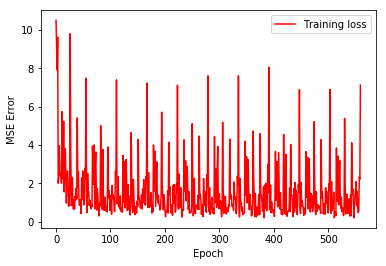

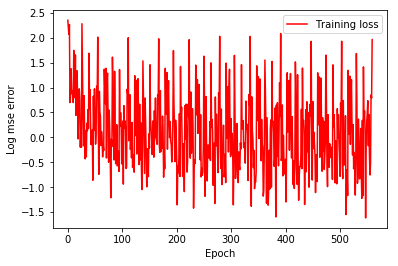

In [8]:
    #################################################################################
    ###########                 after training statistics                 ###########
    #################################################################################
    print ("*******************  Loss with time  **********************")
    fig00 = plt.figure()
    plt.plot(hist, 'r', label="Training loss")
    plt.xlabel('Epoch')
    plt.ylabel('MSE Error')
    plt.legend()
    fig00.savefig(os.path.join(output_path,'BBConvLSTM_train_mse_error.png'),dpi=150)
    
    print ("*******************  Loss with time (log)  **********************")
    fig01 = plt.figure()
    plt.plot(np.log(hist), 'r', label="Training loss")
    plt.xlabel('Epoch')
    plt.ylabel('Log mse error')
    plt.legend()
    plt.show()
    fig01.savefig(os.path.join(output_path,'BBConvLSTM_train_log_mse_error.png'),dpi=150)

In [ ]:
    # plot the error
    print ("*******************  Loss with time  **********************")
    fig00 = plt.figure()
    plt.plot(hist_valance, 'r', label="Training loss - valance")
    plt.plot(hist_arousal, 'b', label="Training loss - arousal")
    plt.xlabel('Sample')
    plt.ylabel('MSE Error')
    plt.legend()
    fig00.savefig(os.path.join(output_path,'BBConvLSTM_pred_mse_error.png'),dpi=150)
    
    #####################################################################################
    ########         visualization of prediction and implement metrics           ########
    #####################################################################################
    # compute mse
    mse_valance = MSE(label_c_test_valance, pred_valance)
    print(mse_valance)
    mse_arousal = MSE(label_c_test_arousal, pred_arousal)
    print(mse_arousal)
    # save output as csv file
    with open(os.path.join(output_path, "MSE_BBConvLSTM_emotion.csv"), "wt+") as fp:
        writer = csv.writer(fp, delimiter=",")
        writer.writerow(["emotion prediction"])  # write header
        writer.writerow(["label valance"])
        writer.writerow([mse_valance])
        writer.writerow(["label arousal"])
        writer.writerow([mse_arousal])